# Big Data in Finance: Part II <BR><BR> Homework 3: Factor Investing - Factor Returns
    
**Instructor** <BR>
Lira Mota, lmota20@gsb.columbia.edu
    
**TA's:** <BR>
Daheng Yang, dyang22@gsb.columbia.edu

**Goal:** As promised, by the end of Part II of the Big Data course, we should be able to replicate Fama and French 5 factors and Momentum factor. We have replicated MOM factor together in class. In this homework you are going to calculate the returns for each of the 5-factors, i.e., portfolio returns for the long-short portfolio that buys a high characteristic and shorts the low characteristic (SMB, HML, RMW and CMA). The firth factor is the excess returns of the market. 

**Delivery:** Upload on canvas a .zip file with your code (it might include .ipynb or .py), your answers (.html notebook is a good choice) and git log with at least 3 commits. 

**Deadline:** Monday, March 2 at 3:59pm. Late assigments will *not* be accepted. 



## Setup
For this homework you need an extra package that you can find in the Bitbucket repository [here](https://bitbucket.org/liramota/fire_pytools/). 

fire_pytools stands for (FI)nance (RE)search python tools and contains a bunch of useful functions, including data download, portfolio sorts, etc.

If you decide to download the fire_pytools to separate folder, the best way to use an external library in pycharm is by adding the library PATH to your project. Check [here](https://www.jetbrains.com/help/pycharm/configuring-content-roots.html) if you have problems.

## Set Up/Skeleton

We are going to use the portfolio allocations we calculated in homework two. For your convenience, the portfolio allocations are also calculated in ff_five_factors_skeleton.py.

Notice that the building blocks are the data sets stock_annual and stock_monthly.

## Calculate Factor Returns

Follow the definition of SMB, HML, RMW and CMA from Ken French's website [here](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/Data_Library/f-f_5_factors_2x3.html).

The first step is to calculate the monthly returns of 6 value-weight portfolios formed on size and book-to-market, the 6 value-weight portfolios formed on size and operating profitability, and the 6 value-weight portfolios formed on size and investment. The portfolio weights should be melag.

The second step is to calculate the factor returns. 

## Questions
----
For all questions consider the time period from 1963 to 2019.

**Question 1 (25 pts)**

For each one of the the 3 characteristics (BEME, OP and INV), plot the time series of cumulative log-returns for each of the 6 value-weight portfolios (BEME X ME, OP X ME and INV X ME).


**Question 2 (25 pts)**

Plot the time series of cumulative log-returns for each of the 3 SMB components, i.e., $SMB_{BEME}$, $SMB_{OP}$ and $SMB_{INV}$.

**Question 3 (25 pts)**

Plot the time series of cumulative log-returns for each of the 4 factors, i.e., SMB, HML, RMW and INV.

**Question 4 (25 pts)**

Compare your factor with the ones reported in Ken French's website. Report the mean, volatility, Sharpe-ratio and correlations.



In [2]:
# %% Packages

import sys
sys.path.append('/Users/ianhojy/Desktop/Big Data in Finance/big_data_code/fire_pytools/')

from pylab import *

from import_kf.kf_factors import *

import data_setup.stock_annual as stock_annual
import data_setup.stock_monthly as stock_monthly

from utils.monthly_date import *

from portools.find_breakpoints import find_breakpoints
from portools.sort_portfolios import sort_portfolios

desired_width = 10
pd.set_option('display.width', desired_width)
idx = pd.IndexSlice

# %% Set Up

char_breakpoints = {'me': [0.5],
                    'beme': [0.3, 0.7],
                    'opbe': [0.3, 0.7],
                    'inv': [0.3, 0.7]}

weightvar = 'melag_weights'

retvar = 'retadj'

dict_factors = {'beme': 'hml',
                'me': 'smb',
                'opbe': 'rmw',
                'inv': 'cma'}

# %% Download Data
# FF five factor
ff = kf_factors(ff_factor_file='F-F_Research_Data_5_Factors_2x3', freq='monthly')
ff.drop(columns=['date'], inplace=True)
ff_ret = ff.set_index('mdate')/100

# Annual Data

varlist = ['conm', 'fyear', 'fyr', 'at', 'capx', 'ceq', 'cogs', 'dlc', 'ib', 'icapt', 'itcb', 'lt', 'mib',
            'naicsh', 'pstk', 'pstkl', 'pstkrv',  'sale', 'seq', 'sich', 'sstk', 'txdb', 'txdi', 'txditc',
            'xint', 'xsga']
adata = stock_annual.main(varlist=varlist, complete_table=False)

# Monthly Data
mdata = stock_monthly.main()

# Set names
adata.rename(columns={'mesum_june': 'me', 'inv_gvkey': 'inv'}, inplace=True) #inv_permco
mdata.rename(columns={weightvar: 'weightvar', retvar: 'retvar'}, inplace=True)

# %% Create Filters
# Global Filters: applied to all portfolio sorts

# valid return
# ------------
print('Data deleted due to missing return: %f' % np.round(mdata.retvar.isnull().mean()*100, 2))
rdata = mdata[mdata.retvar.notnull()]

# shrcd must be (10,11)
# ---------------------
print('Data deleted due to shrcd: %f' % np.round((1-adata.shrcd.isin([10, 11]).mean())*100, 2))
sort_data = adata[adata.shrcd.isin([10, 11])].copy()

# exchcd must be (1, 2, 3)
# ------------------------
print('Data deleted due to exchcd: %f' % np.round((1-sort_data.exchcd.isin([1, 2, 3]).mean())*100, 2))
sort_data = sort_data[sort_data.exchcd.isin([1, 2, 3])]

#del adata, mdata

# Portfolio Specif Filters
sortvars = [*char_breakpoints]

# Define the break point filters
# ------------------------------
bp_filters = [None] * len(sortvars)
bp_filters = dict(zip(sortvars, bp_filters))

# Define the sample filter
# ------------------------
sample_filters = [None] * len(sortvars)
sample_filters = dict(zip(sortvars, sample_filters))

for sortvar in sortvars:
    # notice that the way we defined beme or beme is null if be<=0
    bp_filters[sortvar] = (sort_data[sortvar].notnull())
    sample_filters[sortvar] = ((sort_data.me > 0) & (sort_data.mesum_dec > 0) & (sort_data[sortvar].notnull()))

# %% Find Breakpoints
# The number of firms Ken French reports for each characteristic sort varies. This means his universe of stocks
# for sorting changes across characteristics. That is why we need to calculate breakpoints separately.
breakpoints = [None] * len(sortvars)
breakpoints = dict(zip(sortvars, bp_filters))

for sortvar in sortvars:
    breakpoints[sortvar] = find_breakpoints(data=sort_data[bp_filters[sortvar]],
                                            quantiles={sortvar: char_breakpoints[sortvar]},
                                            id_variables=['rankyear', 'permno', 'exchcd'],
                                            exch_cd=[1]
                                            )

# %% Portfolio Sorts
portsorts = [None] * len(sortvars)
portsorts = dict(zip(sortvars, bp_filters))

for sortvar in sortvars:
    portsorts[sortvar] = sort_portfolios(data=sort_data[sample_filters[sortvar]],
                                         quantiles={sortvar: char_breakpoints[sortvar]},
                                         id_variables=['rankyear', 'permno', 'exchcd'],
                                         breakpoints={sortvar: breakpoints[sortvar]}
                                         )

# merge all separate portfolio allocations together
port = portsorts['me'].copy()
for sortvar in sortvars[1:]:
    # Notice that this is an outer join
    port = port.merge(portsorts[sortvar], on=['permno', 'rankyear'], how='outer')

# %% Calculate rertuns
# Notice that this is a inner join
port_ret = pd.merge(port, rdata, on=['rankyear', 'permno'])

# TODO: calculate returns of long-short portfolios (SMB, HML, RMW, CMA)


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


Stock annual calculation started.
Enter your WRDS username [ianhojy]:ianhojy
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done
Compustat data was successfully downloaded in 79.20671796798706 seconds.
Pension data was successfully downloaded in 2.4120421409606934 seconds.
CRSP data was successfully downloaded in 148.94058799743652 seconds.
CRSP and Compsuat merge created 6 (fyear, permno) duplicates.
Keeping only the last available datadate per PERMNO.
There are 81664 PERMNOs without a valid PERMCO in DFF BE data: not present in the stock names table.
Number of not valid PERMCOs in lcomp: 0
Number of entries with valis sich:
0.046
Number of entries with valis sich_filled:
0.003
Time to create stock_annual: 277.7677161693573 seconds
Stock monthly calculation started.
Enter your WRDS username [ianhojy]:ianhojy
Enter your password:········
WRDS recom

### Filtering Data: 1963 - 2019

In [13]:
port_ret = port_ret[port_ret.rankyear >= 1963].reset_index().drop('index', axis=1)

**Question 1 (25 pts)**

For each one of the the 3 characteristics (BEME, OP and INV), plot the time series of cumulative log-returns for each of the 6 value-weight portfolios (BEME X ME, OP X ME and INV X ME).

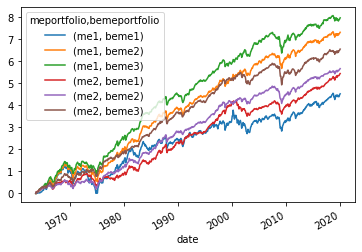

In [14]:
### BEME

beme = port_ret.groupby(['date','meportfolio','bemeportfolio']).apply(
        lambda x: np.average(x['retvar'], weights=x['weightvar']))
beme = beme.unstack(level=[1,2])
np.log(1+beme).cumsum().plot()

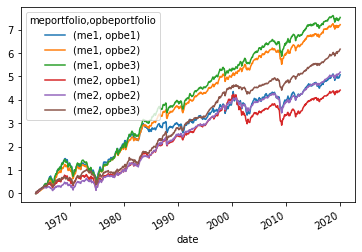

In [15]:
### OP

op = port_ret.groupby(['date','meportfolio','opbeportfolio']).apply(
        lambda x: np.average(x['retvar'], weights=x['weightvar']))
op = op.unstack(level=[1,2])
np.log(1+op).cumsum().plot()

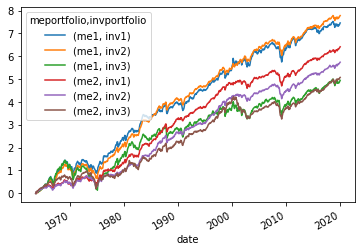

In [16]:
### INV

inv = port_ret.groupby(['date','meportfolio','invportfolio']).apply(
        lambda x: np.average(x['retvar'], weights=x['weightvar']))
inv = inv.unstack(level=[1,2])
np.log(1+inv).cumsum().plot()


**Question 2 (25 pts)**

Plot the time series of cumulative log-returns for each of the 3 SMB components, i.e., $SMB_{BEME}$, $SMB_{OP}$ and $SMB_{INV}$.

In [17]:
size = pd.DataFrame()
size['beme'] = beme.loc[:, 'me1'].mean(axis=1) - beme.loc[:,'me2'].mean(axis=1)
size['op'] = op.loc[:, 'me1'].mean(axis=1) - op.loc[:,'me2'].mean(axis=1)
size['inv'] = inv.loc[:, 'me1'].mean(axis=1) - inv.loc[:,'me2'].mean(axis=1)


Text(0.5, 1.0, 'Cumulative log-returns for SMB-BEME')

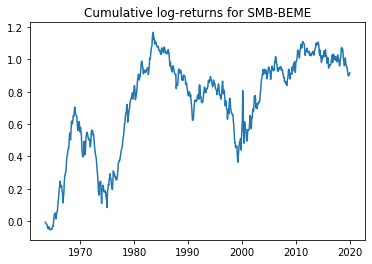

In [18]:
plt.plot(np.log(1+size.beme).cumsum())
plt.title('Cumulative log-returns for SMB-BEME')

Text(0.5, 1.0, 'Cumulative log-returns for SMB-OP')

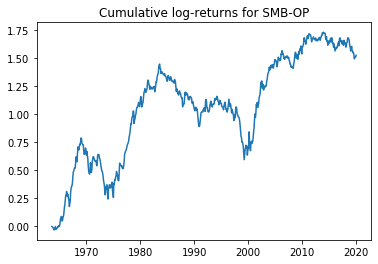

In [19]:
plt.plot(np.log(1+size.op).cumsum())
plt.title('Cumulative log-returns for SMB-OP')

Text(0.5, 1.0, 'Cumulative log-returns for SMB-INV')

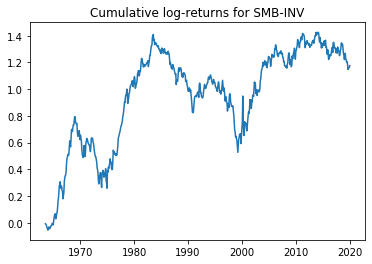

In [20]:
plt.plot(np.log(1+size.inv).cumsum())
plt.title('Cumulative log-returns for SMB-INV')

**Question 3 (25 pts)**

Plot the time series of cumulative log-returns for each of the 4 factors, i.e., SMB, HML, RMW and INV.

In [21]:
### BEME

beme['beme_ret'] = beme.loc[:, idx[:,'beme3']].mean(axis=1) - beme.loc[:, idx[:, 'beme1']].mean(axis=1)
plt.plot(np.log(1+beme.beme_ret).cumsum())
plt.title('Cumulative log-returns for HML factor')

Text(0.5, 1.0, 'Cumulative log-returns for HML factor')

Text(0.5, 1.0, 'Cumulative log-returns for RMW factor')

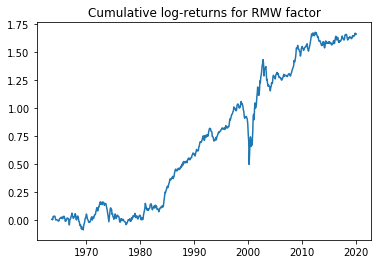

In [22]:
### OP

op['op_ret'] = op.loc[:, idx[:,'opbe3']].mean(axis=1) - op.loc[:, idx[:, 'opbe1']].mean(axis=1)
plt.plot(np.log(1+op.op_ret).cumsum())
plt.title('Cumulative log-returns for RMW factor')

Text(0.5, 1.0, 'Cumulative log-returns for INV factor')

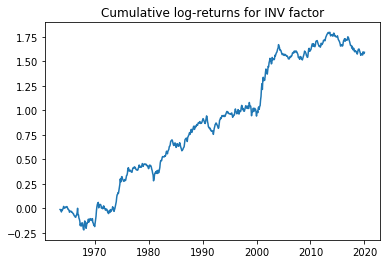

In [23]:
### INV

inv['inv_ret'] = inv.loc[:, idx[:,'inv1']].mean(axis=1) - inv.loc[:, idx[:, 'inv3']].mean(axis=1)
plt.plot(np.log(1+inv.inv_ret).cumsum())
plt.title('Cumulative log-returns for INV factor')

Text(0.5, 1.0, 'Cumulative log-returns for SMB factor')

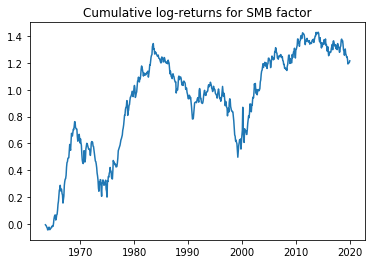

In [24]:
size['size_ret'] = (size['beme'] + size['op'] + size['inv']) / 3
plt.plot(np.log(1+size.size_ret).cumsum())
plt.title('Cumulative log-returns for SMB factor')

**Question 4 (25 pts)**

Compare your factor with the ones reported in Ken French's website. Report the mean, volatility, Sharpe-ratio and correlations.

HML factor correlation is: 0.99612


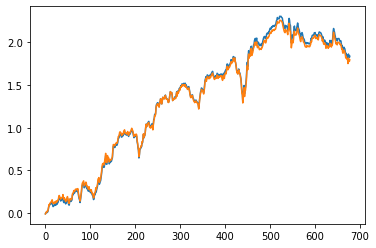

In [25]:
### COMPARING HML

beme_compare = pd.DataFrame(beme['beme_ret'])
beme_compare.reset_index(inplace=True)
beme_compare['mdate'] = beme_compare['date'].apply(monthly_date)
beme_compare = beme_compare.join(ff_ret[['HML']], on='mdate')
beme_compare = beme_compare[['beme_ret','HML']]
beme_compare = beme_compare.dropna()
print('HML factor correlation is: '+str('%.5f'%beme_compare.corr().iloc[0,1]))
plt.plot(np.log(1+beme_compare).cumsum())
plt.show()



In [26]:
### COMPARING RMW

op_compare = pd.DataFrame(op['op_ret'])
op_compare.reset_index(inplace=True)
op_compare['mdate'] = op_compare['date'].apply(monthly_date)
op_compare = op_compare.join(ff_ret[['RMW']], on='mdate')
op_compare = op_compare[['op_ret','RMW']]
op_compare = op_compare.dropna()
print('RMW factor correlation is: '+str('%.5f'%op_compare.corr().iloc[0,1]))
plt.plot(np.log(1+op_compare).cumsum())
plt.show()


RMW factor correlation is: 0.98785


CMA/INV factor correlation is: 0.98252


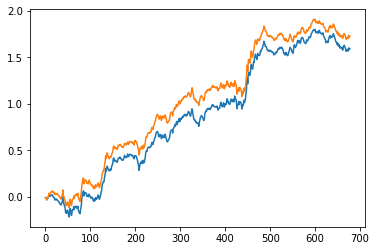

In [27]:
### COMPARING CMA/INV

inv_compare = pd.DataFrame(inv['inv_ret'])
inv_compare.reset_index(inplace=True)
inv_compare['mdate'] = inv_compare['date'].apply(monthly_date)
inv_compare = inv_compare.join(ff_ret[['CMA']], on='mdate')
inv_compare = inv_compare[['inv_ret','CMA']]
inv_compare = inv_compare.dropna()
print('CMA/INV factor correlation is: '+str('%.5f'%inv_compare.corr().iloc[0,1]))
plt.plot(np.log(1+inv_compare).cumsum())
plt.show()


SMB factor correlation is: 0.99829


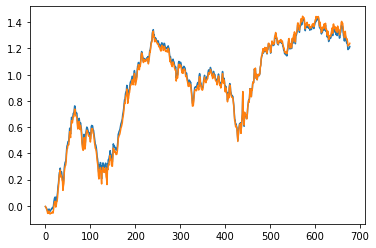

In [28]:
### COMPARING SMB

size_compare = pd.DataFrame(size['size_ret'])
size_compare.reset_index(inplace=True)
size_compare['mdate'] = size_compare['date'].apply(monthly_date)
size_compare = size_compare.join(ff_ret[['SMB']], on='mdate')
size_compare = size_compare[['size_ret','SMB']]
size_compare = size_compare.dropna()
print('SMB factor correlation is: '+str('%.5f'%size_compare.corr().iloc[0,1]))
plt.plot(np.log(1+size_compare).cumsum())
plt.show()


In [29]:
### SUMMARY STATISTICS, BUT MERGE FIRST

merge = beme[['beme_ret']].join(op[['op_ret']],on='date').join(inv[['inv_ret']],on='date').join(size[['size_ret']],on='date')
merge = merge.dropna()
merge.columns = ['HML','RMW','CMA','SMB']



/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/core/reshape/merge.py:618: UserWarning: merging between different levels can give an unintended result (2 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [30]:
### MEAN

print('\n Factor Mean(%): \n')
print(merge.mean() * 12 * 100)

print('\n FF Mean(%): \n')
print(ff_ret.mean()[[2,3,4,1]] * 12 * 100)



 Factor Mean(%): 

HML    3.726511
RMW    3.250074
CMA    3.053124
SMB    2.675383
dtype: float64

 FF Mean(%): 

HML    3.533196
RMW    3.080059
CMA    3.245479
SMB    2.651664
dtype: float64


In [31]:
### VOLATILITY

print('\n Factor Vol(%): \n')
print(merge.std() * np.sqrt(12) * 100)

print('\n FF Vol(%): \n')
print(ff_ret.std()[[2,3,4,1]] * np.sqrt(12) * 100)



 Factor Vol(%): 

HML     9.740761
RMW     7.852528
CMA     6.833040
SMB    10.271061
dtype: float64

 FF Vol(%): 

HML     9.759571
RMW     7.466406
CMA     6.903363
SMB    10.425249
dtype: float64


In [32]:
#????? negative
### SHARPE RATIO

rf = ff_ret['RF'].mean()*12*100

print('\n Factor SR: \n')
print(((merge.mean() * 12 * 100) - rf ) / (merge.std() * np.sqrt(12) * 100))

print('\n FF SR: \n')
print(((ff_ret.mean()[[2,3,4,1]] * 12 * 100) - rf ) / (ff_ret.std()[[2,3,4,1]] * np.sqrt(12) * 100))




 Factor SR: 

HML   -0.083209
RMW   -0.163890
CMA   -0.217166
SMB   -0.181251
dtype: float64

 FF SR: 

HML   -0.102856
RMW   -0.195136
CMA   -0.187089
SMB   -0.180846
dtype: float64


In [33]:
# CORRELATION 

print('\n Factor Correlation:')
merge.corr()


 Factor Correlation:


HML  \
HML  1.000000   
RMW  0.092383   
CMA  0.691904   
SMB -0.054909   

          RMW  \
HML  0.092383   
RMW  1.000000   
CMA -0.046681   
SMB -0.353772   

          CMA  \
HML  0.691904   
RMW -0.046681   
CMA  1.000000   
SMB -0.080219   

          SMB  
HML -0.054909  
RMW -0.353772  
CMA -0.080219  
SMB  1.000000

In [34]:
print('\n FF Correlation: \n')
ff_ret.iloc[:,[2,3,4,1]].corr()


 FF Correlation: 



HML  \
HML  1.000000   
RMW  0.065413   
CMA  0.695973   
SMB -0.058479   

          RMW  \
HML  0.065413   
RMW  1.000000   
CMA -0.032875   
SMB -0.344629   

          CMA  \
HML  0.695973   
RMW -0.032875   
CMA  1.000000   
SMB -0.100433   

          SMB  
HML -0.058479  
RMW -0.344629  
CMA -0.100433  
SMB  1.000000